In [1]:
import pymongo
import pandas as pd
import numpy as np
import csv
import pybacktest
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtGlobal import globalSetting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dbName = 'VnTrader_5min_Db'
symbol = 'rb88'
# 从数据库加载rb88的行情数据
c = pymongo.MongoClient()
col = c[dbName][symbol]
cx = col.find()
l = list(cx)

In [3]:
# 转换成DataFrame
d = {}
for key in l[0].keys():
    d[key] = []
for data in l:
    for k, v in data.items():
        d[k].append(v)
        
df = pd.DataFrame.from_dict(d)

In [4]:
# 转换成pybacktest
ohlc = df.copy()
ohlc.drop(['_id', 'date','time', 'exchange', 'gatewayName','openInterest', 'rawData','symbol', 'vtSymbol','volume'],axis=1,inplace=True)
ohlc.rename(columns={'open': 'O', 'close':'C','high':'H','low':'L','datetime':'datetime'},inplace=True)
ohlc = ohlc.set_index(pd.to_datetime(ohlc['datetime']))
ohlc.drop('datetime',axis=1,inplace=True)
ohlc.head()

,C,H,L,O
datetime,,,,
2016-01-04 09:10:00,1809.0,1820.0,1805.0,1818.0
2016-01-04 09:15:00,1808.0,1813.0,1808.0,1809.0
2016-01-04 09:20:00,1806.0,1808.0,1802.0,1808.0
2016-01-04 09:25:00,1804.0,1806.0,1801.0,1806.0
2016-01-04 09:30:00,1809.0,1809.0,1804.0,1805.0


## 三均线策略

In [168]:
#计算均线信号
ma1_L = 10
ma2_L = 20
ma3_L = 120
ma1 = ohlc['C'].rolling(window = ma1_L,center = False).mean()
ma2 = ohlc['C'].rolling(window = ma2_L,center = False).mean()
ma3 = ohlc['C'].rolling(window = ma3_L,center = False).mean()
ma3_ma5 =  ma3.rolling(window = 5, center = False).mean()
ma2_ma5 = ma2.rolling(window = 5, center = False).mean()
ma1_ma5 = ma1.rolling(window = 5, center = False).mean()

In [150]:
#生成信号
# MA10 上穿MA20， MA10 > MA120， bar.close > MA120
buy = (ma1>ma2) &(ma1.shift(1) < ma2.shift(1))&(ma1>ma1_ma5)&(ma2>ma2_ma5)
# MA10 下穿MA20， MA10 < MA120， bar.close < MA120
short = (ma1.shift(1) > ma2.shift(1))&(ma1 < ma2)&(ma1<ma1_ma5)&(ma2<ma2_ma5)

In [151]:
# MA10下穿MA20，多单离场
sell =(ma1.shift(1) > ma2.shift(1))&(ma1 < ma2)
# MA10上穿MA20，空离场
cover =(ma1.shift(1) < ma2.shift(1))&(ma1 > ma2)

In [152]:
bt = pybacktest.Backtest(locals(), 'Triple MA(10,20,120,5min,rb88)_v1')

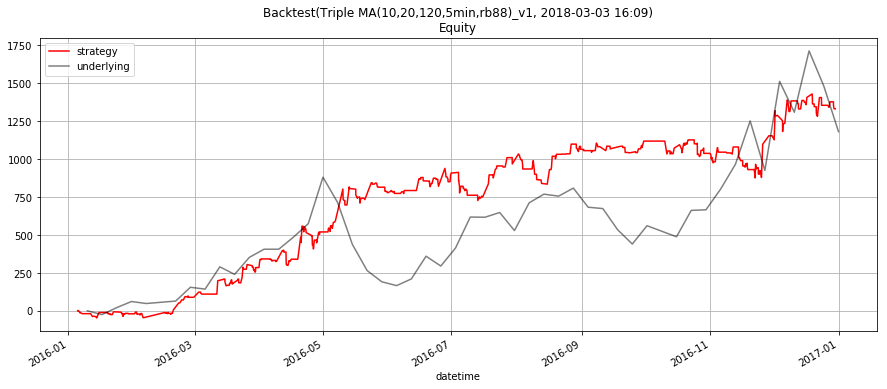

In [153]:
plt.figure(figsize=(15,6))
bt.plot_equity()
plt.grid(True)

In [154]:
bt.summary()

-------------------------------------------------------------------
|  Backtest(Triple MA(10,20,120,5min,rb88)_v1, 2018-03-03 16:09)  |
-------------------------------------------------------------------

backtest:
  days: !!python/long '359'
  from: '2016-01-05 11:30:00'
  to: '2016-12-29 21:35:00'
  trades: 373
performance:
  PF: 1.3763
  RF: 5.3068
  averages:
    gain: 32.2649
    loss: -15.9459
    trade: 3.571
  payoff: 2.0234
  profit: 1332.0
  winrate: 0.4048
risk/return profile:
  MPI: 1.4946
  UPI: 0.0481
  WCDD (monte-carlo 0.99 quantile): 675.8
  maxdd: 251.0
  sharpe: 1.7012
  sortino: 2.4263

-------------------------------------------------------------------


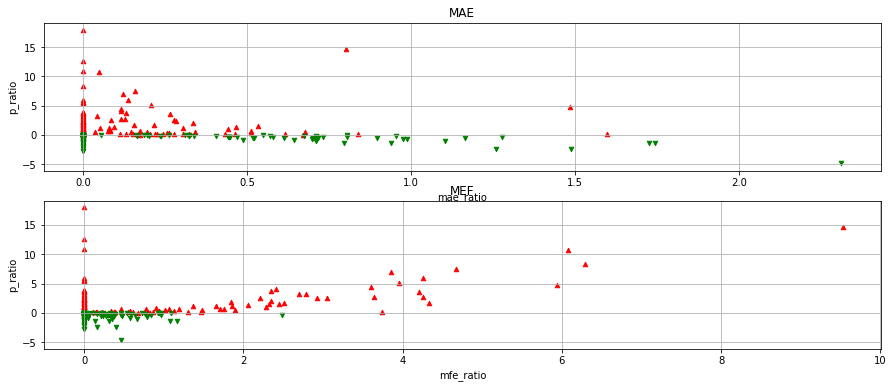

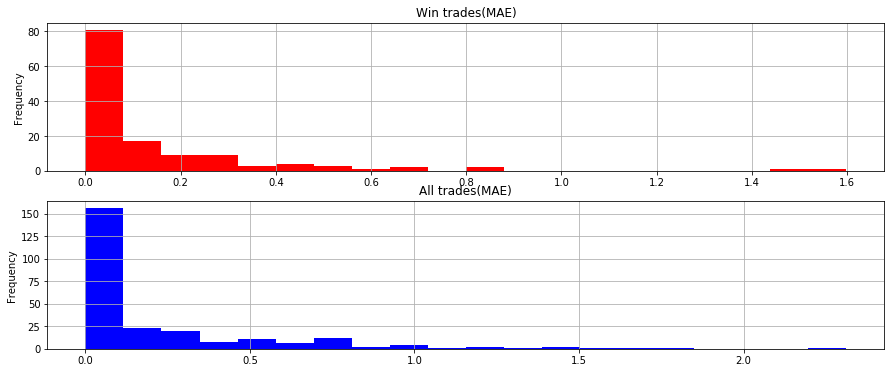

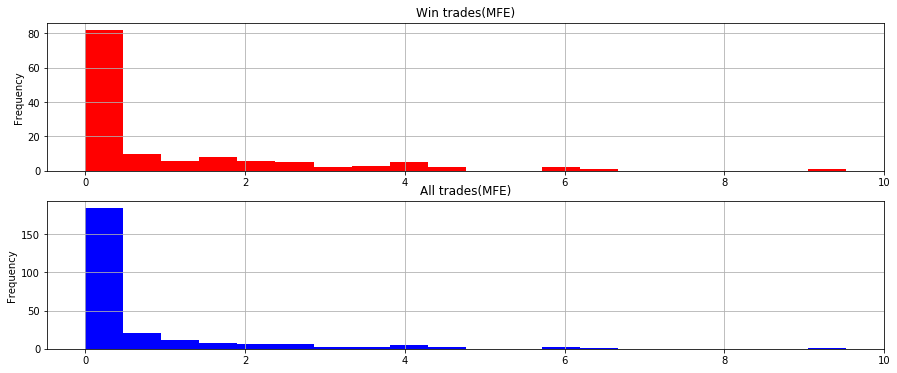

In [155]:
bt.plot_maef(True)

## BollinggerBot策略

In [16]:
import talib
import pybacktest

In [41]:
 # 策略参数
bollWindow = 28         # 通道窗口数
entryDev = 3.2          # 开仓偏差
exitDev = 2           # 平仓偏差
maWindow = 10           # 过滤用均线窗口

In [42]:
bollMid = talib.SMA(ohlc.C.values, bollWindow)
bollStd = talib.STDDEV(ohlc.C.values, bollWindow)
entryUp = bollMid + bollStd * entryDev
exitUp = bollMid - bollStd * exitDev
ma = ohlc.C.rolling(window=10).mean()

In [43]:
buy = (ohlc.C > entryUp)&(ohlc.C > ma)&(ma>ma.shift(1))
sell = (ohlc.C < exitUp)

In [44]:
bt = pybacktest.Backtest(locals(),'BollingerBot(5min,rb88)_v1' )

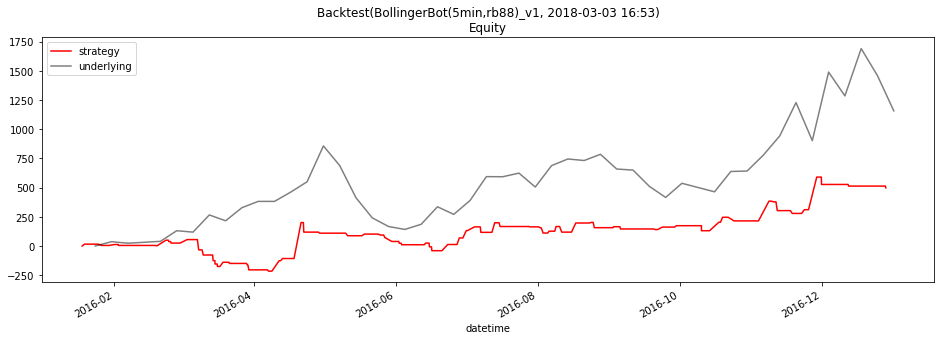

In [45]:
plt.figure(figsize=(16,5))
bt.plot_equity()